CELL 7: COMPLETE TRAINING PIPELINE

[PART A] Rebuilding data pipeline...
Total frames: 176,256
Train: 149,817 | Val: 26,439
Train batches: 1,248 | Val batches: 221

[PART B] Building CILRS model...
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 213MB/s]


Model parameters: 22,421,453

[PART C] Training setup...

STARTING TRAINING: 20 epochs

Epoch 1/20 (lr=0.000100)
    Batch 300/1248 | Loss: 0.7094
    Batch 600/1248 | Loss: 0.5360
    Batch 900/1248 | Loss: 0.4552
    Batch 1200/1248 | Loss: 0.4042
  Train | Total:0.3975 Steer:0.0329 Thr:0.0956 Brk:0.1349 Spd:0.0044
  Val   | Total:0.1945 Steer:0.0168 Thr:0.0543 Brk:0.0543 Spd:0.0034
  Cmd Steer: FOLLOW=0.0168 LEFT=0.0168 RIGHT=0.0193 STRAIGHT=0.0136
  Time: 453.6s
  ★ Best model saved! (val_loss=0.1945)

Epoch 2/20 (lr=0.000100)
    Batch 300/1248 | Loss: 0.2323
    Batch 600/1248 | Loss: 0.2233
    Batch 900/1248 | Loss: 0.2160
    Batch 1200/1248 | Loss: 0.2103
  Train | Total:0.2093 Steer:0.0163 Thr:0.0554 Brk:0.0714 Spd:0.0021
  Val   | Total:0.1370 Steer:0.0119 Thr:0.0406 Brk:0.0363 Spd:0.0014
  Cmd Steer: FOLLOW=0.0105 LEFT=0.0137 RIGHT=0.0139 STRAIGHT=0.0110
  Time: 352.1s
  ★ Best model saved! (val_loss=0.1370)

Epoch 3/20 (lr=0.000100)
    Batch 300/1248 | Loss: 0.1768
    B

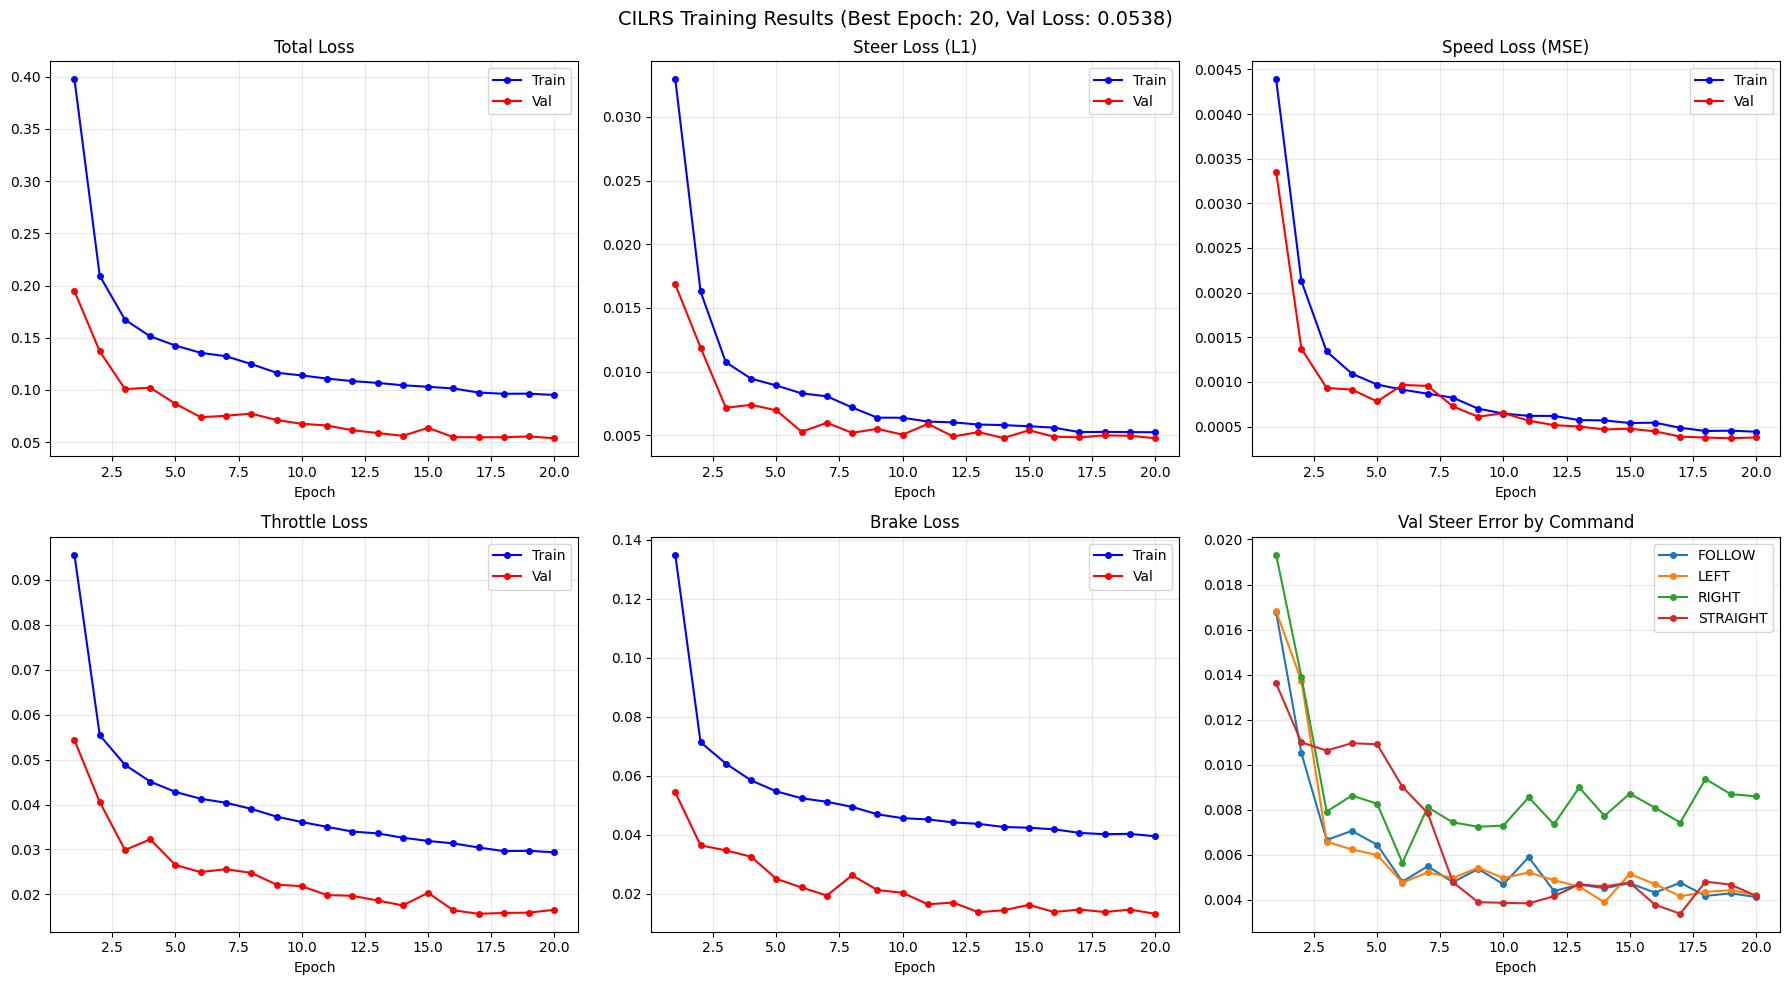


--- Output Files ---
  __notebook__.ipynb: 0.0 MB
  checkpoint_best.pth: 256.9 MB
  checkpoint_latest.pth: 256.9 MB
  training_curves.png: 0.3 MB
  training_history.csv: 0.0 MB

*** checkpoint_best.pth is the model you need to download ***
*** After notebook finishes, go to Output tab to download it ***

ALL DONE! You can download checkpoint_best.pth from Output tab


In [1]:
# =============================================================================
# CELL 7: FULL TRAINING + AUTO-SAVE FOR DOWNLOAD
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import cv2
import time
import os
import json
import pickle
import warnings
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from collections import Counter
from sklearn.model_selection import train_test_split
import albumentations as A

warnings.filterwarnings("ignore", category=UserWarning)

print("=" * 60)
print("CELL 7: COMPLETE TRAINING PIPELINE")
print("=" * 60)

# =================================================================
# PART A: Rebuild everything (in case session restarted)
# =================================================================
print("\n[PART A] Rebuilding data pipeline...")

DATA_DIR = "/kaggle/input/carla-09-dataset/training_data"
BATCH_SIZE = 120
NUM_WORKERS = 2
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
COMMAND_MAP = {"LANEFOLLOW": 0, "LEFT": 1, "RIGHT": 2, "STRAIGHT": 3}

# Load all sessions
sessions = sorted([d for d in os.listdir(DATA_DIR) 
                   if os.path.isdir(os.path.join(DATA_DIR, d)) and "session" in d])
all_dfs = []
for s in sessions:
    df = pd.read_csv(os.path.join(DATA_DIR, s, "measurements.csv"))
    df["session"] = s
    df["image_path"] = df["image_filename"].apply(
        lambda x: os.path.join(DATA_DIR, s, "images", x))
    df["command_idx"] = df["command_name"].map(COMMAND_MAP)
    all_dfs.append(df)

full_df = pd.concat(all_dfs, ignore_index=True)
print(f"Total frames: {len(full_df):,}")

# Train/Val split
train_df, val_df = train_test_split(full_df, test_size=0.15, random_state=42, 
                                      stratify=full_df["command_idx"])
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(f"Train: {len(train_df):,} | Val: {len(val_df):,}")

# Oversampling weights
train_cmd_counts = train_df["command_idx"].value_counts().to_dict()
class_weights = {i: len(train_df) / (4 * train_cmd_counts.get(i, 1)) for i in range(4)}

# Augmentation (Albumentations 2.x API)
train_augmentation = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=15, p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.GaussNoise(std_range=(0.02, 0.06), p=0.3),
    A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(4, 10),
                     hole_width_range=(8, 20), fill=0, p=0.2),
])

# Dataset class
class CILRSDataset(Dataset):
    def __init__(self, dataframe, augmentation=None):
        self.df = dataframe.reset_index(drop=True)
        self.augmentation = augmentation
        self.normalize = transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row["image_path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.augmentation is not None:
            img = self.augmentation(image=img)["image"]
        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1)
        img = self.normalize(img)
        speed = torch.tensor(row["speed_normalized"], dtype=torch.float32)
        command = torch.tensor(row["command_idx"], dtype=torch.long)
        targets = torch.tensor([row["steer"], row["throttle"], row["brake"]], dtype=torch.float32)
        return img, speed, command, targets

# DataLoaders
sample_weights = train_df["command_idx"].map(class_weights).values
train_sampler = WeightedRandomSampler(torch.DoubleTensor(sample_weights), 
                                        num_samples=len(train_df), replacement=True)

train_dataset = CILRSDataset(train_df, augmentation=train_augmentation)
val_dataset = CILRSDataset(val_df, augmentation=None)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler,
                           num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)

print(f"Train batches: {len(train_loader):,} | Val batches: {len(val_loader):,}")

# =================================================================
# PART B: Model
# =================================================================
print("\n[PART B] Building CILRS model...")

class CILRS(nn.Module):
    def __init__(self, num_commands=4, dropout=0.5):
        super(CILRS, self).__init__()
        self.num_commands = num_commands
        resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        self.visual_encoder = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4,
            resnet.avgpool, nn.Flatten(),
        )
        self.speed_encoder = nn.Sequential(
            nn.Linear(1, 128), nn.ReLU(inplace=True), nn.Dropout(dropout),
            nn.Linear(128, 128), nn.ReLU(inplace=True),
        )
        combined_dim = 640
        self.control_branches = nn.ModuleList()
        for _ in range(num_commands):
            self.control_branches.append(nn.Sequential(
                nn.Linear(combined_dim, 256), nn.ReLU(inplace=True), nn.Dropout(dropout),
                nn.Linear(256, 256), nn.ReLU(inplace=True), nn.Dropout(dropout),
                nn.Linear(256, 3),
            ))
        self.speed_predictor = nn.Sequential(
            nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(dropout),
            nn.Linear(256, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )
    
    def forward(self, image, speed, command):
        visual_features = self.visual_encoder(image)
        speed_features = self.speed_encoder(speed.unsqueeze(1))
        combined = torch.cat([visual_features, speed_features], dim=1)
        pred_speed = self.speed_predictor(visual_features).squeeze(1)
        batch_size = image.size(0)
        all_outputs = torch.stack([branch(combined) for branch in self.control_branches], dim=0)
        command_idx = command.unsqueeze(0).unsqueeze(2).expand(1, batch_size, 3)
        controls = all_outputs.gather(0, command_idx).squeeze(0)
        return controls, pred_speed

device = torch.device("cuda")
model = CILRS(num_commands=4, dropout=0.5).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")

# =================================================================
# PART C: Training Configuration
# =================================================================
print("\n[PART C] Training setup...")

CONFIG = {
    "epochs": 20,
    "batch_size": BATCH_SIZE,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "lr_step_size": 8,
    "lr_gamma": 0.5,
    "steer_loss_weight": 5.0,
    "throttle_loss_weight": 1.0,
    "brake_loss_weight": 1.0,
    "speed_loss_weight": 0.5,
    "grad_clip": 1.0,
    "patience": 6,
}

class CILRSLoss(nn.Module):
    def __init__(self, steer_w=5.0, throttle_w=1.0, brake_w=1.0, speed_w=0.5):
        super().__init__()
        self.steer_w = steer_w
        self.throttle_w = throttle_w
        self.brake_w = brake_w
        self.speed_w = speed_w
        self.l1 = nn.L1Loss()
        self.mse = nn.MSELoss()
    
    def forward(self, pred_controls, target_controls, pred_speed, target_speed):
        steer_loss = self.l1(pred_controls[:, 0], target_controls[:, 0])
        throttle_loss = self.l1(pred_controls[:, 1], target_controls[:, 1])
        brake_loss = self.l1(pred_controls[:, 2], target_controls[:, 2])
        control_loss = (self.steer_w * steer_loss + 
                       self.throttle_w * throttle_loss + 
                       self.brake_w * brake_loss)
        speed_loss = self.mse(pred_speed, target_speed)
        total_loss = control_loss + self.speed_w * speed_loss
        return total_loss, {
            "total": total_loss.item(), "control": control_loss.item(),
            "steer": steer_loss.item(), "throttle": throttle_loss.item(),
            "brake": brake_loss.item(), "speed": speed_loss.item(),
        }

criterion = CILRSLoss(
    steer_w=CONFIG["steer_loss_weight"], throttle_w=CONFIG["throttle_loss_weight"],
    brake_w=CONFIG["brake_loss_weight"], speed_w=CONFIG["speed_loss_weight"],
)
optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"], 
                        weight_decay=CONFIG["weight_decay"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=CONFIG["lr_step_size"], 
                                        gamma=CONFIG["lr_gamma"])

# =================================================================
# PART D: Training Loop
# =================================================================
def train_one_epoch(model, loader, criterion, optimizer, device, grad_clip):
    model.train()
    losses = {k: 0.0 for k in ["total", "control", "steer", "throttle", "brake", "speed"]}
    n = 0
    for batch_idx, (imgs, speeds, cmds, tgts) in enumerate(loader):
        imgs, speeds, cmds, tgts = (imgs.to(device, non_blocking=True), 
            speeds.to(device, non_blocking=True), cmds.to(device, non_blocking=True), 
            tgts.to(device, non_blocking=True))
        pred_ctrl, pred_spd = model(imgs, speeds, cmds)
        loss, ld = criterion(pred_ctrl, tgts, pred_spd, speeds)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        for k, v in ld.items():
            losses[k] += v
        n += 1
        if (batch_idx + 1) % 300 == 0:
            print(f"    Batch {batch_idx+1}/{len(loader)} | Loss: {losses['total']/n:.4f}")
    return {k: v/n for k, v in losses.items()}

def validate(model, loader, criterion, device):
    model.eval()
    losses = {k: 0.0 for k in ["total", "control", "steer", "throttle", "brake", "speed"]}
    cmd_errors = {i: [] for i in range(4)}
    n = 0
    with torch.no_grad():
        for imgs, speeds, cmds, tgts in loader:
            imgs, speeds, cmds, tgts = (imgs.to(device, non_blocking=True),
                speeds.to(device, non_blocking=True), cmds.to(device, non_blocking=True),
                tgts.to(device, non_blocking=True))
            pred_ctrl, pred_spd = model(imgs, speeds, cmds)
            loss, ld = criterion(pred_ctrl, tgts, pred_spd, speeds)
            for k, v in ld.items():
                losses[k] += v
            n += 1
            serr = (pred_ctrl[:, 0] - tgts[:, 0]).abs()
            for ci in range(4):
                mask = cmds == ci
                if mask.any():
                    cmd_errors[ci].extend(serr[mask].cpu().numpy().tolist())
    cmd_names = {0: "FOLLOW", 1: "LEFT", 2: "RIGHT", 3: "STRAIGHT"}
    cmd_avg = {cmd_names[i]: np.mean(e) if e else float('nan') for i, e in cmd_errors.items()}
    return {k: v/n for k, v in losses.items()}, cmd_avg

print(f"\n{'='*60}")
print(f"STARTING TRAINING: {CONFIG['epochs']} epochs")
print(f"{'='*60}\n")

best_val_loss = float("inf")
best_epoch = 0
patience_counter = 0
history = []
total_start = time.time()

for epoch in range(1, CONFIG["epochs"] + 1):
    ep_start = time.time()
    lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch}/{CONFIG['epochs']} (lr={lr:.6f})")
    
    train_losses = train_one_epoch(model, train_loader, criterion, optimizer, device, CONFIG["grad_clip"])
    val_losses, cmd_errs = validate(model, val_loader, criterion, device)
    scheduler.step()
    
    ep_time = time.time() - ep_start
    
    print(f"  Train | Total:{train_losses['total']:.4f} Steer:{train_losses['steer']:.4f} "
          f"Thr:{train_losses['throttle']:.4f} Brk:{train_losses['brake']:.4f} Spd:{train_losses['speed']:.4f}")
    print(f"  Val   | Total:{val_losses['total']:.4f} Steer:{val_losses['steer']:.4f} "
          f"Thr:{val_losses['throttle']:.4f} Brk:{val_losses['brake']:.4f} Spd:{val_losses['speed']:.4f}")
    print(f"  Cmd Steer: " + " ".join(f"{k}={v:.4f}" for k, v in cmd_errs.items()))
    print(f"  Time: {ep_time:.1f}s")
    
    history.append({
        "epoch": epoch, "lr": lr,
        "train_total": train_losses["total"], "train_steer": train_losses["steer"],
        "train_throttle": train_losses["throttle"], "train_brake": train_losses["brake"],
        "train_speed": train_losses["speed"],
        "val_total": val_losses["total"], "val_steer": val_losses["steer"],
        "val_throttle": val_losses["throttle"], "val_brake": val_losses["brake"],
        "val_speed": val_losses["speed"],
        **{f"cmd_{k}": v for k, v in cmd_errs.items()},
        "time": ep_time,
    })
    
    if val_losses["total"] < best_val_loss:
        best_val_loss = val_losses["total"]
        best_epoch = epoch
        patience_counter = 0
        torch.save({
            "epoch": epoch, "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_losses["total"], "val_steer": val_losses["steer"],
            "config": CONFIG, "cmd_steer_errors": cmd_errs,
        }, "/kaggle/working/checkpoint_best.pth")
        print(f"  ★ Best model saved! (val_loss={best_val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{CONFIG['patience']})")
    
    torch.save({
        "epoch": epoch, "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
    }, "/kaggle/working/checkpoint_latest.pth")
    
    print()
    
    if patience_counter >= CONFIG["patience"]:
        print(f"Early stopping at epoch {epoch}!")
        break

total_time = time.time() - total_start

# =================================================================
# PART E: Training Plots + Summary
# =================================================================
print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)
print(f"Total time: {total_time/60:.1f} minutes")
print(f"Best epoch: {best_epoch}")
print(f"Best val loss: {best_val_loss:.4f}")

history_df = pd.DataFrame(history)
history_df.to_csv("/kaggle/working/training_history.csv", index=False)

# Plot training curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Total loss
ax = axes[0, 0]
ax.plot(history_df["epoch"], history_df["train_total"], "b-o", label="Train", markersize=4)
ax.plot(history_df["epoch"], history_df["val_total"], "r-o", label="Val", markersize=4)
ax.set_title("Total Loss")
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(True, alpha=0.3)

# Steer loss
ax = axes[0, 1]
ax.plot(history_df["epoch"], history_df["train_steer"], "b-o", label="Train", markersize=4)
ax.plot(history_df["epoch"], history_df["val_steer"], "r-o", label="Val", markersize=4)
ax.set_title("Steer Loss (L1)")
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(True, alpha=0.3)

# Speed loss
ax = axes[0, 2]
ax.plot(history_df["epoch"], history_df["train_speed"], "b-o", label="Train", markersize=4)
ax.plot(history_df["epoch"], history_df["val_speed"], "r-o", label="Val", markersize=4)
ax.set_title("Speed Loss (MSE)")
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(True, alpha=0.3)

# Throttle loss
ax = axes[1, 0]
ax.plot(history_df["epoch"], history_df["train_throttle"], "b-o", label="Train", markersize=4)
ax.plot(history_df["epoch"], history_df["val_throttle"], "r-o", label="Val", markersize=4)
ax.set_title("Throttle Loss")
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(True, alpha=0.3)

# Brake loss
ax = axes[1, 1]
ax.plot(history_df["epoch"], history_df["train_brake"], "b-o", label="Train", markersize=4)
ax.plot(history_df["epoch"], history_df["val_brake"], "r-o", label="Val", markersize=4)
ax.set_title("Brake Loss")
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(True, alpha=0.3)

# Per-command steer error
ax = axes[1, 2]
for cmd in ["FOLLOW", "LEFT", "RIGHT", "STRAIGHT"]:
    col = f"cmd_{cmd}"
    if col in history_df.columns:
        ax.plot(history_df["epoch"], history_df[col], "-o", label=cmd, markersize=4)
ax.set_title("Val Steer Error by Command")
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle(f"CILRS Training Results (Best Epoch: {best_epoch}, Val Loss: {best_val_loss:.4f})", 
             fontsize=14)
plt.tight_layout()
plt.savefig("/kaggle/working/training_curves.png", dpi=150)
plt.show()

# =================================================================
# PART F: Final file listing
# =================================================================
print("\n--- Output Files ---")
for f in sorted(os.listdir("/kaggle/working/")):
    fpath = os.path.join("/kaggle/working/", f)
    if os.path.isfile(fpath):
        sz = os.path.getsize(fpath) / (1024*1024)
        print(f"  {f}: {sz:.1f} MB")

print(f"\n*** checkpoint_best.pth is the model you need to download ***")
print(f"*** After notebook finishes, go to Output tab to download it ***")

print("\n" + "=" * 60)
print("ALL DONE! You can download checkpoint_best.pth from Output tab")
print("=" * 60)